In [1]:
import mne
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.stats import pearsonr
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from utils import merge_eeg_fmri
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

Add tensorboard support

In [2]:
from torch.utils.tensorboard import SummaryWriter
import datetime
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S") # Generate a timestamp or unique identifier
writer = SummaryWriter(os.path.join('./logs', timestamp))

Load EEG and fMRI data and assign to raw objects (with EEG: channels 1-31, and fMRI: channels 32-33)

Function merg_eeg_fmri:
Adds the fmri time courses to the eeg raw file as additional misc channels. 
It uses cubic splines to interpolate the fmri data to the eeg sampling rate
It also shifts the fmri data by offset seconds (e.g 7 seconds). If offset>0, the fmri data are shifted to the left 
(earlier in time). If offset<0, the fmri data are shifted to the right (delayed in time)
Most likely, eeg data will be able to predict future fmri values (thus, use offset>0)

Used Annotations descriptions: ['S  1', 'S255', 'Sync On', 'T  1', 'boundary']
Used Annotations descriptions: ['S  1', 'S255', 'Sync On', 'T  1', 'boundary']
Creating RawArray with float64 data, n_channels=2, n_times=151200
    Range : 0 ... 151199 =      0.000 ...   604.796 secs
Ready.


f:\MYPROJECTS_GITHUB\eegfMRIprediction_project\eegfmri_regression\utils.py:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eegfile, preload=True)


Used Annotations descriptions: ['S  1', 'S255', 'Sync On', 'T  1', 'boundary']
Used Annotations descriptions: ['S  1', 'S255', 'Sync On', 'T  1', 'boundary']
Creating RawArray with float64 data, n_channels=2, n_times=154640
    Range : 0 ... 154639 =      0.000 ...   618.556 secs
Ready.


f:\MYPROJECTS_GITHUB\eegfMRIprediction_project\eegfmri_regression\utils.py:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eegfile, preload=True)


Used Annotations descriptions: ['S  1', 'S255', 'Sync On', 'T  1', 'boundary']
Used Annotations descriptions: ['S  1', 'S255', 'Sync On', 'T  1', 'boundary']
Creating RawArray with float64 data, n_channels=2, n_times=156650
    Range : 0 ... 156649 =      0.000 ...   626.596 secs
Ready.


f:\MYPROJECTS_GITHUB\eegfMRIprediction_project\eegfmri_regression\utils.py:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eegfile, preload=True)


Used Annotations descriptions: ['S  1', 'S255', 'Sync On', 'T  1']
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Using matplotlib as 2D backend.


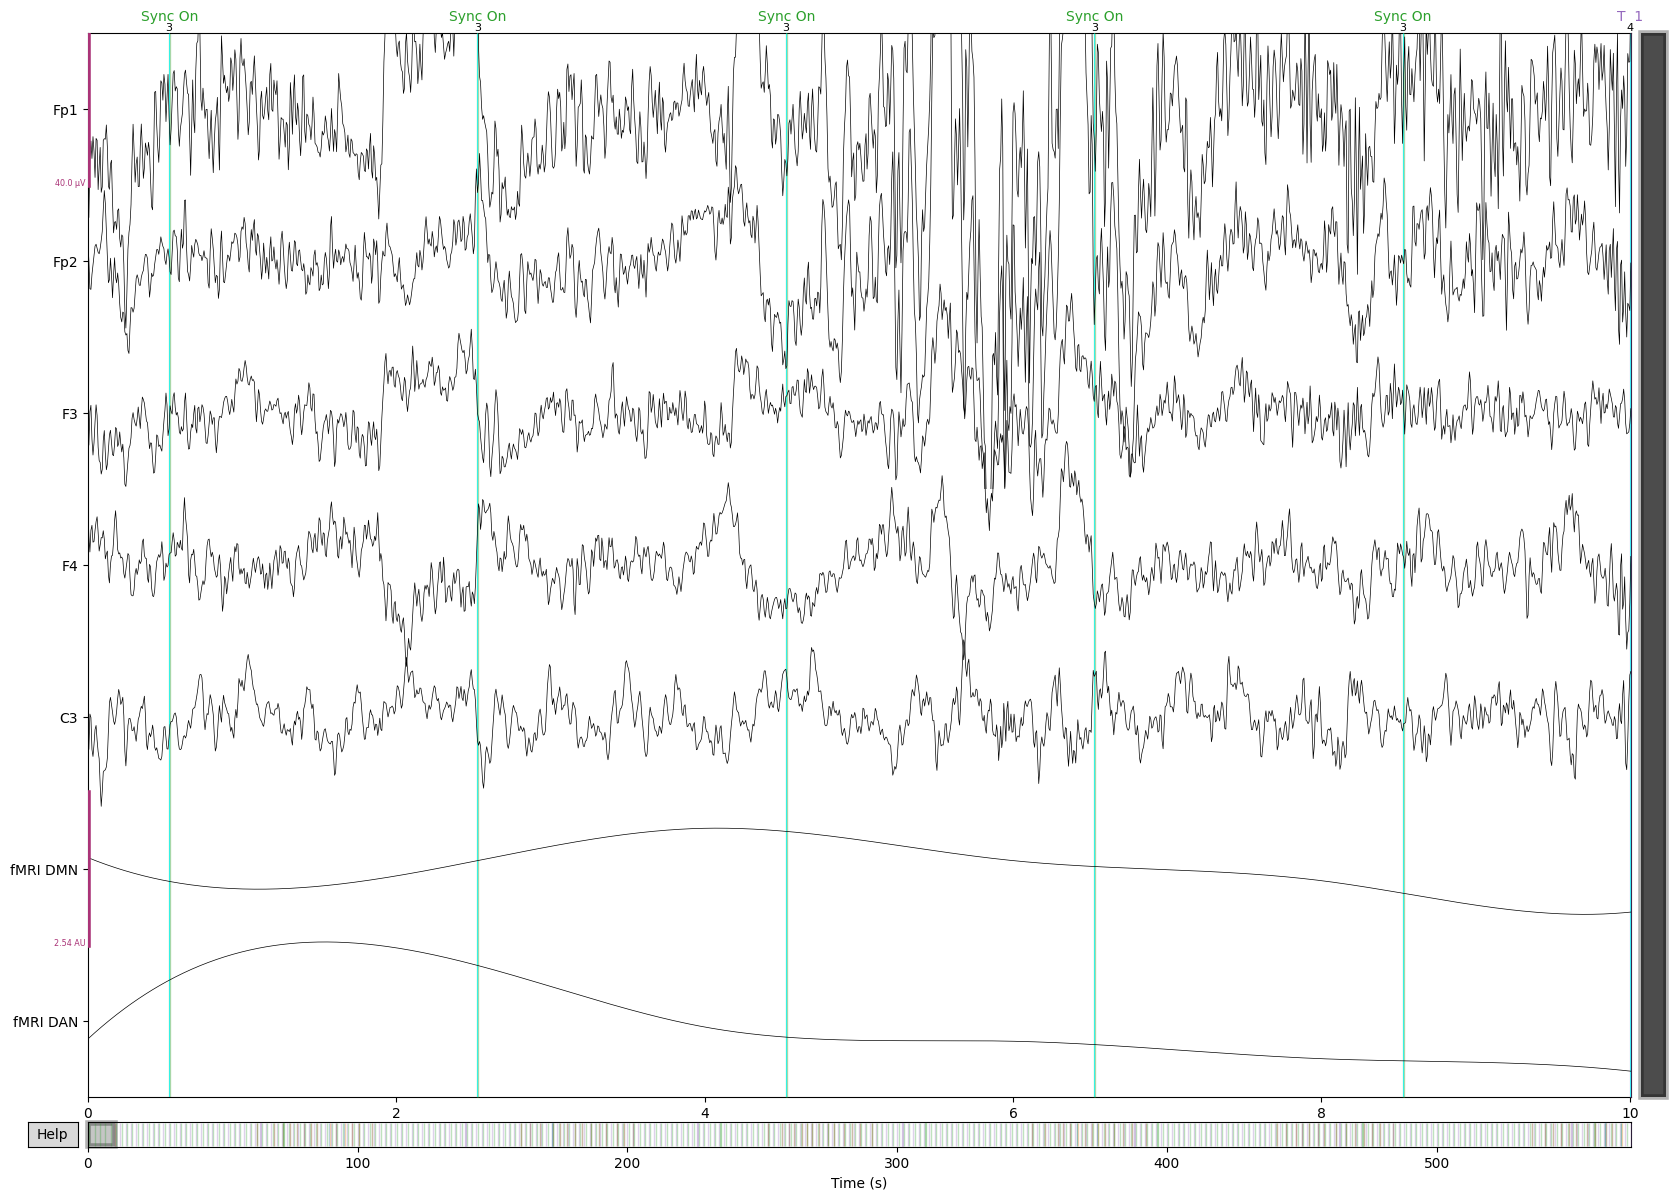

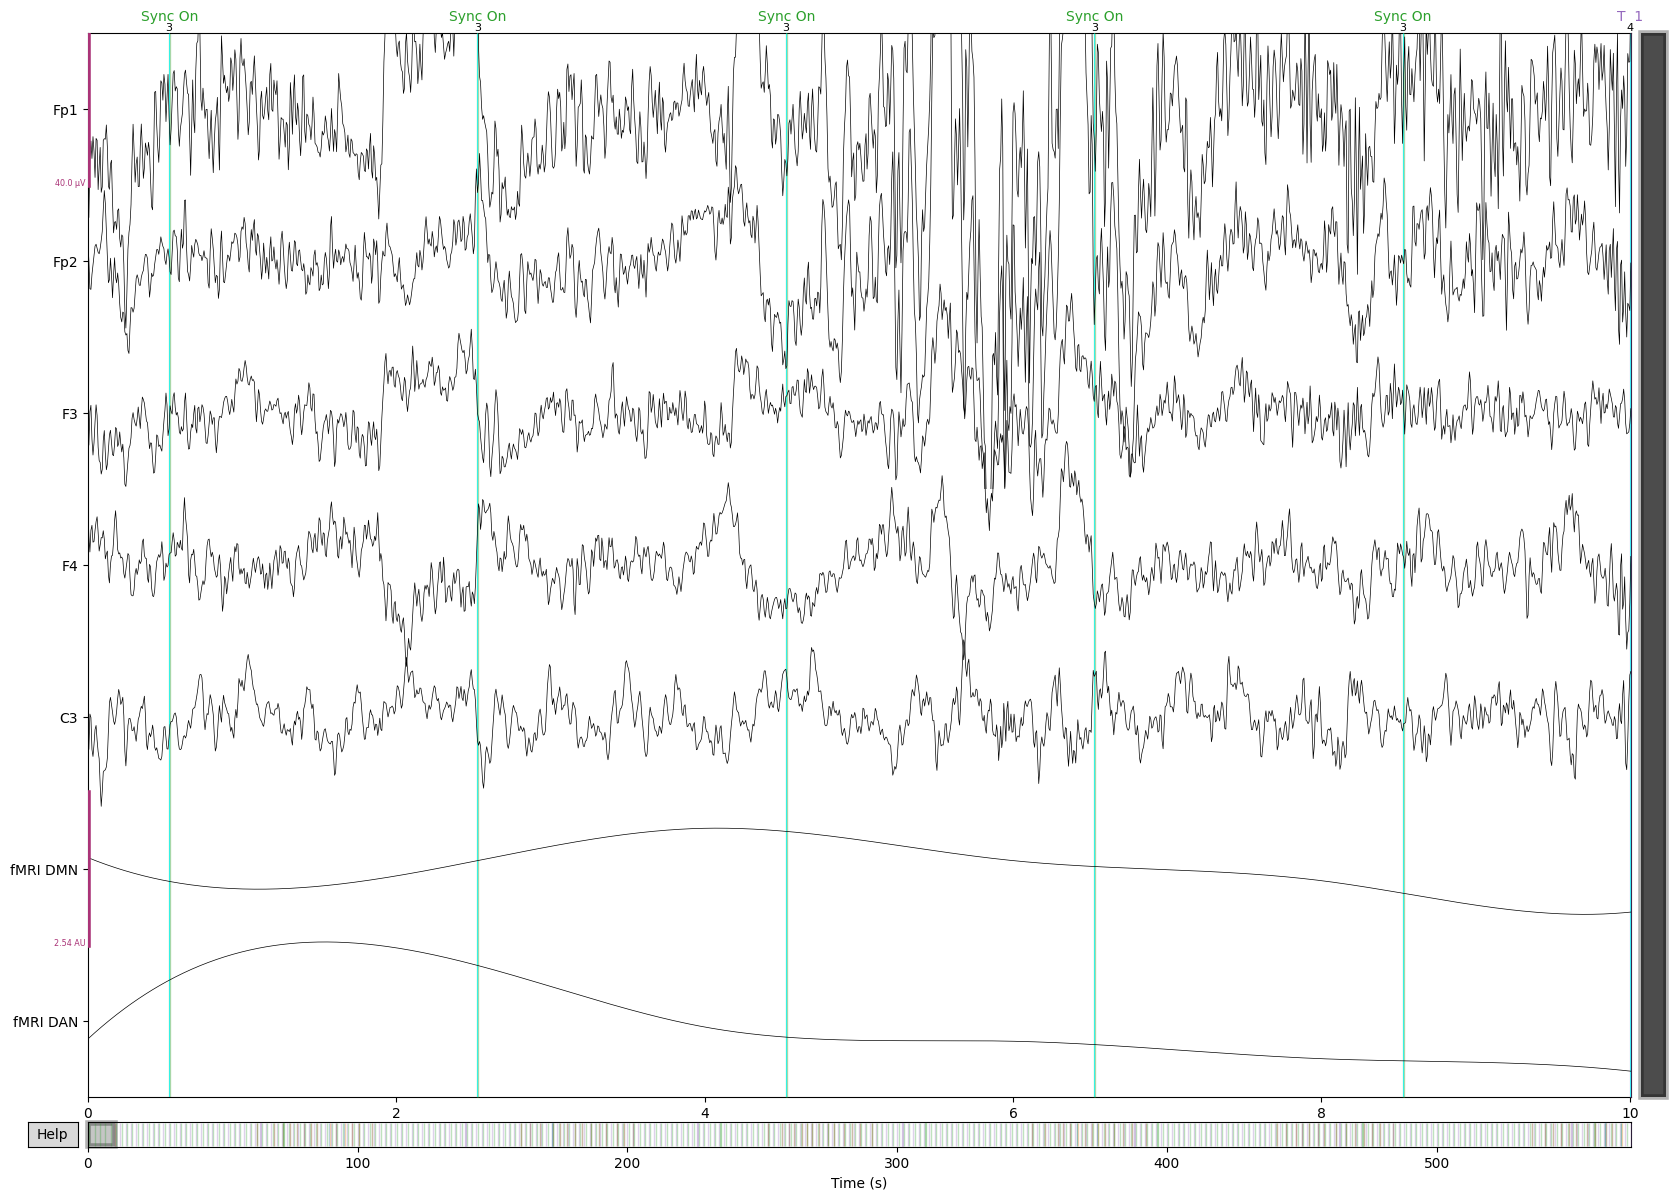

In [3]:
offset = 10 #relative offset of fMRI wrt EEG data (positive to predict)
sess=2
raw = []
for run in range(1,4):
    data_path = os.path.join(os.getcwd(),'eegfmri_data','sub-004')
    eegfile = os.path.join(data_path,f'ses-00{sess}','eeg',f'sub-004_ses-00{sess}_task-ExperienceSampling_run-00{run}_eeg_Bergen_CWreg_cleaned.set')
    fmrifile_dmn = os.path.join(data_path,f'ses-00{sess}','func','ROI_percentSC',f'DMN_Standard_sub-004_ses-00{sess}_task-ExperienceSampling_run-00{run}_bold_MNI_percentSC.txt')
    fmrifile_dan = os.path.join(data_path,f'ses-00{sess}','func','ROI_percentSC',f'DAN_Standard_sub-004_ses-00{sess}_task-ExperienceSampling_run-00{run}_bold_MNI_percentSC.txt')
    raw.append(merge_eeg_fmri(eegfile,fmrifile_dmn,fmrifile_dan, offset))

# Plot a few channels of first raw file
events, event_id = mne.events_from_annotations(raw[0])
selected_channels = raw[0].ch_names[:5] + raw[0].ch_names[-2:]
raw[0].copy().pick_channels(selected_channels).plot(events=events)



Define train/valid/test datasets
X_train, X_valid, X_test for EEG data where each is nchannels x ntimes
y_train, y_valid, y_test for targets (channels 32 and 33) where each is 2 x ntimes

In [4]:
X_train = raw[0].get_data()[:-2,:].transpose()
y_train = raw[0].get_data()[-2:,:].transpose()
X_valid = raw[1].get_data()[:-2,:].transpose()
y_valid = raw[1].get_data()[-2:,:].transpose()
X_test = raw[2].get_data()[:-2,:].transpose()
y_test = raw[2].get_data()[-2:,:].transpose()
print(X_train.shape)
print(y_train.shape)

(85801, 31)
(85801, 2)


Normalize all data to zero mean unit variance based on the train set, and then apply PCA

In [5]:
# Define the pipeline
flagPCA = True #do PCA on EEG to compress dimension?
if flagPCA: 
    n_components = 5 # Specify the number of principal components
    pipeline = Pipeline([('scaler', StandardScaler()),('pca', PCA(n_components=n_components))])
else:
    pipeline = Pipeline([('scaler', StandardScaler())])
X_train = pipeline.fit_transform(X_train) # Fit and transform the training data
X_valid = pipeline.transform(X_valid) # Transform the validation data
X_test = pipeline.transform(X_test) # Transform the test data


Convert data to PyTorch tensors

In [6]:
X_train_tensor = torch.tensor(X_train[np.newaxis,:,:], dtype=torch.float32)
y_train_tensor = torch.tensor(y_train[np.newaxis,:,:], dtype=torch.float32)
X_valid_tensor = torch.tensor(X_valid[np.newaxis,:,:], dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid[np.newaxis,:,:], dtype=torch.float32)
X_test_tensor = torch.tensor(X_test[np.newaxis,:,:], dtype=torch.float32)
y_test_tensor = torch.tensor(y_test[np.newaxis,:,:], dtype=torch.float32)
print(X_train_tensor.shape) # batch x sequence x features(channels)

torch.Size([1, 85801, 5])


Define parameters

In [7]:
input_channels = X_train_tensor.shape[2]  # Channels to used as input
output_channels = y_train_tensor.shape[2]  # Channels to be used as output
seq_length = X_train_tensor.shape[1]  # Length of each sequence
batch_size = 1 #we train with only one session
num_layers = 2 #perhaps 2 LSTM layers will do well (no need for more)
hidden_size = 12
learning_rate = 0.05 #perhaps this can be optimized
num_epochs = 500

Define LSTM model

In [8]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        #out = self.fc(out[:, -1, :])  # Use only the last time step's output for prediction
        out = self.fc(out[:, :, :])  # all time step's output for prediction
        return out

Initialize the model, loss function, and optimizer

In [9]:
model = LSTMModel(input_channels, hidden_size, num_layers, output_channels)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

HACKs to test if LSTM works. They change the prediction task.

In [ ]:
# Original task predicts fMRI from EEG
# Hack1 changes the task to predict last EEG channel from other EEG channels  - it works!
hack1 = False
if hack1:
    y_train_tensor[:,:,0] = X_train_tensor[:,:,-1] #set y values as last EEG sensor
    y_train_tensor[:,:,1] = X_train_tensor[:,:,-1] #set y values as last EEG sensor
    X_train_tensor[:,:,-1] = X_train_tensor[:,:,-2] #replace last EEG sensor with the one before the last
    y_valid_tensor[:,:,0] = X_valid_tensor[:,:,-1] #same for validation set
    y_valid_tensor[:,:,1] = X_valid_tensor[:,:,-1]
    X_valid_tensor[:,:,-1] = X_valid_tensor[:,:,-2]

#hack2 changes the task to use EEG + fMRI time course 0 to predict fmri time course 1 - it does not work
hack2 = False
if hack2:
    X_train_tensor[:,:,-1] = y_train_tensor[:,:,0] #last EEG time course is replaced with fMRI time course 0
    y_train_tensor[:,:,0] = y_train_tensor[:,:,1] #fMRI time course 0 is replaced with fMRI time course 1
    X_valid_tensor[:,:,-1] = y_valid_tensor[:,:,0] #same for validation set
    y_valid_tensor[:,:,0] = y_valid_tensor[:,:,1] 

Training loop

In [ ]:
for epoch in range(num_epochs):

    # Forward pass
    out = model.forward(X_train_tensor)
    loss = criterion(out, y_train_tensor)  #MSELoss: o = np.mean(np.square(out.detach().numpy() - y_train_tensor.numpy()))

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        with torch.no_grad():
            out_valid = model.forward(X_valid_tensor)
            loss_valid = criterion(out_valid, y_valid_tensor) 
            print(f"Epoch: {epoch}, Loss: {loss.item():.4f}, Valid Loss: {loss_valid.item():.4f}")

            writer.add_scalar('train loss', loss.item(), epoch) # write to tensorflow log
            writer.add_scalar('valid loss', loss_valid.item(), epoch)
            writer.flush()


-->Epoch: 0, Loss: 0.7911, Valid Loss: 0.8020
-->Epoch: 10, Loss: 0.7824, Valid Loss: 0.7856
-->Epoch: 20, Loss: 0.7748, Valid Loss: 0.7909


Plot fit for train data

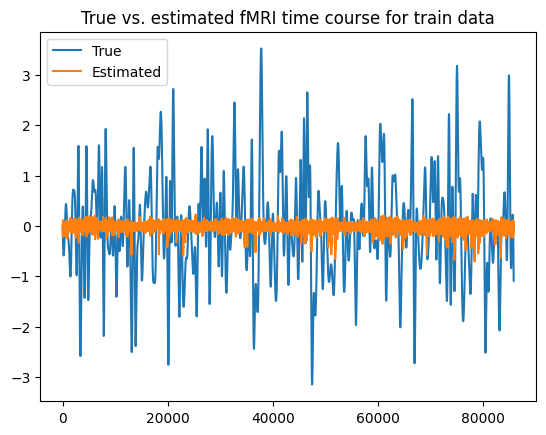

In [ ]:
plt.figure()
plt.title('True vs. estimated fMRI time course for train data')
plt.plot(y_train_tensor[:,:,0].numpy().transpose()) #plot true train time course
plt.plot(out[:,:,0].detach().numpy().transpose()) #plot estimated time course
plt.legend(['True','Estimated'])
plt.show()

Plot fit for validation data

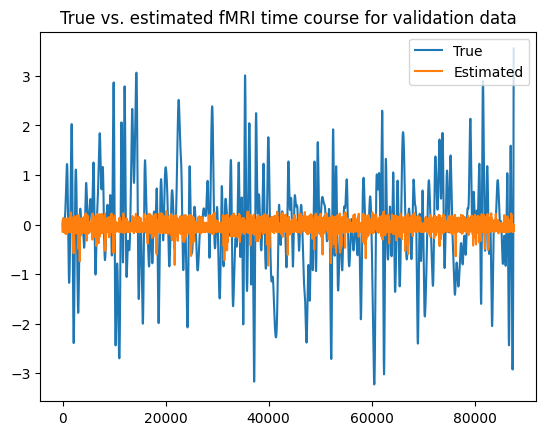

In [ ]:
plt.figure()
plt.title('True vs. estimated fMRI time course for validation data')
plt.plot(y_valid_tensor[:,:,0].numpy().transpose()) #plot true train time course
plt.plot(out_valid[:,:,0].detach().numpy().transpose()) #plot estimated time course
plt.legend(['True','Estimated'])
plt.show()